In [1]:
#cnet_model.ipynb 
# 
#by Joe Hahn
#joe.hahn@oracle.com
#30 July 2018
#
#train a cnet model on the XO dataset

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 15
initial_id = 0

In [3]:
#start time
import time as tm
time_start = tm.time()

In [4]:
#adjust balance of training data so that X class is 2x more abundant that O,B
N_dots = 26700
X_boost = 2.0
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
df = rebalance_df(df, X_boost=X_boost)
print df.groupby('class')['id'].count()
train = df
train.tail(5)

class
B    1786
O    1786
X    3572
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score
7139,26689,0.516272,-3.868010,3.902312,-1.438108,O,0.0,1.0,0.0
7140,4718,-0.682553,0.790124,1.044115,2.283280,X,1.0,0.0,0.0
7141,19652,-4.218945,4.304971,6.027626,2.346103,X,1.0,0.0,0.0
7142,6454,-2.581265,-0.353564,2.605367,-3.005467,O,0.0,1.0,0.0
7143,8281,3.679994,-3.577766,5.132520,-0.771314,X,1.0,0.0,0.0


In [5]:
#select x-features and y = target variables = class-scores
x_cols = ['x', 'y']
y_cols = ['O_score', 'X_score', 'B_score']
x_train = train[x_cols].values
y_train = train[y_cols].values
print 'x_train.shape = ', x_train.shape
print 'y_train.shape = ', y_train.shape
x_train

x_train.shape =  (7144, 2)
y_train.shape =  (7144, 3)


array([[-0.37101928, -1.98994929],
       [ 0.56894444, -0.53072332],
       [-4.47345234, -0.70640382],
       ...,
       [-4.21894537,  4.30497077],
       [-2.58126516, -0.35356376],
       [ 3.67999446, -3.57776567]])

In [6]:
#generate rebalanced validation data
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
df = rebalance_df(df, X_boost=X_boost)
print df.groupby('class')['id'].count()
x_val = df[x_cols].values
y_val = df[y_cols].values
print 'x_val.shape = ', x_val.shape
print 'y_val.shape = ', y_val.shape
y_val

class
B    1790
O    1790
X    3581
Name: id, dtype: int64
x_val.shape =  (7161, 2)
y_val.shape =  (7161, 3)


array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [7]:
#helper function that builds a cnet classifier
def cnet_classifier(N_input, N_2d, kernel_size, N_output, output_activation_fn):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, BatchNormalization, Activation, Reshape, Conv2D, MaxPooling2D, Flatten
    model = Sequential()
    #input layer
    N = N_2d**2
    input_shape = (N_input,)
    layer = Dense(N, activation='elu', input_shape=input_shape)
    model.add(layer)
    #reshape input layer
    output_shape = (N_2d, N_2d, 1)
    layer = Reshape(output_shape)
    model.add(layer)
    #add Conv2D + MaxPooling2D layers
    layer = Conv2D(1, kernel_size=kernel_size, padding='same', activation='elu')
    model.add(layer)
    pool_size = kernel_size/2
    layer = MaxPooling2D(pool_size=pool_size, strides=pool_size)
    model.add(layer)
    #add Conv2D + MaxPooling2D layers
    layer = Conv2D(1, kernel_size=kernel_size, padding='same', activation='elu')
    model.add(layer)
    layer = MaxPooling2D(pool_size=pool_size, strides=pool_size)
    model.add(layer)
    #flatten + output layer
    layer = Flatten()
    model.add(layer)
    model.add(Dense(N_output, activation=output_activation_fn))
    #set loss function
    if (output_activation_fn == 'linear'):
        loss_fn = 'mean_squared_error'
    if (output_activation_fn == 'sigmoid'):
        loss_fn = 'categorical_crossentropy'
    model.compile(loss=loss_fn, optimizer='adam')
    return model

In [8]:
#build CNET classification model 
N_input = len(x_cols)
N_2d = 100
kernel_size = 6
N_output = len(y_cols)
output_activation_fn = 'linear'
print 'N_input = ', N_input
print 'N_2d = ', N_2d
print 'kernel_size = ', kernel_size
print 'output_activation_fn = ', output_activation_fn
model = cnet_classifier(N_input, N_2d, kernel_size, N_output, output_activation_fn)
model.summary()

N_input =  2
N_2d =  100
kernel_size =  6
output_activation_fn =  linear


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10000)             30000     
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 1)       37        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 1)         37        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 121)               0         
__________

In [9]:
#train model
#...is slow on cpu...this runs 20x faster on AWS gpu instance, and 4x faster on mac laptop...
N_training_epochs = 15
batch_size = 2000
fit_history = model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, 
    verbose=1, validation_data=(x_val, y_val))

Train on 7144 samples, validate on 7161 samples
Epoch 1/15
7144/7144 [==============================] - 272s 38ms/step - loss: 0.3441 - val_loss: 0.2187
Epoch 2/15
7144/7144 [==============================] - 266s 37ms/step - loss: 0.2055 - val_loss: 0.1963
Epoch 3/15
7144/7144 [==============================] - 266s 37ms/step - loss: 0.1900 - val_loss: 0.1823
Epoch 4/15
7144/7144 [==============================] - 269s 38ms/step - loss: 0.1758 - val_loss: 0.1729
Epoch 5/15
7144/7144 [==============================] - 259s 36ms/step - loss: 0.1679 - val_loss: 0.1647
Epoch 6/15
7144/7144 [==============================] - 276s 39ms/step - loss: 0.1597 - val_loss: 0.1584
Epoch 7/15
7144/7144 [==============================] - 264s 37ms/step - loss: 0.1541 - val_loss: 0.1531
Epoch 8/15
7144/7144 [==============================] - 278s 39ms/step - loss: 0.1496 - val_loss: 0.1499
Epoch 9/15
7144/7144 [==============================] - 263s 37ms/step - loss: 0.1469 - val_loss: 0.1475
Epoch 1

In [10]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

final validation loss =  0.14359145857588304


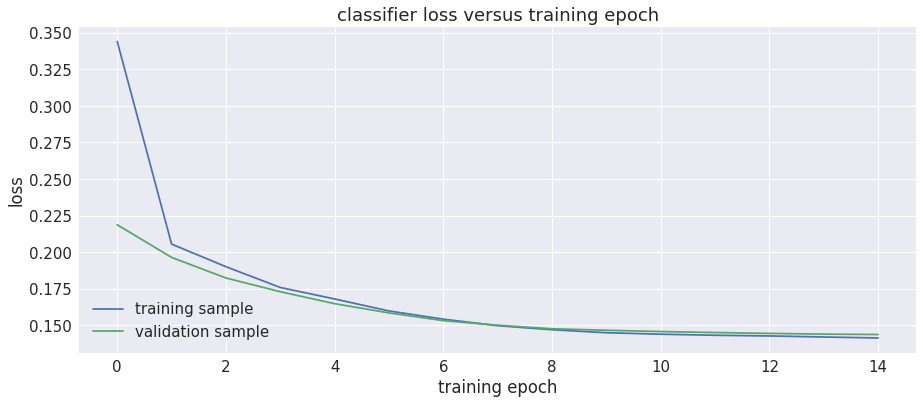

In [11]:
#plot accuracy vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, label='validation sample')
ax.set_title('classifier loss versus training epoch')
ax.set_ylabel('loss')
ax.set_xlabel('training epoch')
ax.legend(loc='lower left')
#ax.set_ylim(0.95*np.min(yp), 1.05*np.max(yp[1:]))
plt.savefig('figs/cnet_loss.png')
print 'final validation loss = ', yp[-1]

In [12]:
#generate class predictions on testing X-O data
N_dots = 20000
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
x = df[x_cols].values
y = df[y_cols].values
y_pred = model.predict(x)
for idx in range(len(y_cols)):
    y_col = y_cols[idx]
    df[y_col] = y_pred[:, idx]
idx = (df.O_score > df.X_score) & (df.O_score > df.B_score)
df.loc[idx, 'class_pred'] = 'O'
idx = (df.X_score > df.B_score) & (df.X_score > df.O_score)
df.loc[idx, 'class_pred'] = 'X'
idx = (df.B_score > df.O_score) & (df.B_score > df.X_score)
df.loc[idx, 'class_pred'] = 'B'
df.head(5)

,id,x,y,r,angle,class,X_score,O_score,B_score,class_pred
record,,,,,,,,,,
0,0,-0.879749,2.061907,2.241744,1.974079,B,0.576749,0.443853,0.020541,X
1,1,-4.177633,1.936199,4.604507,2.707595,B,0.440687,0.222369,0.377859,X
2,2,5.263041,-0.882854,5.336575,-0.166199,B,0.119828,0.276158,0.602456,B
3,3,-6.339135,3.414946,7.200451,2.647460,B,0.441065,-0.026827,0.561979,B
4,4,1.918674,-8.257570,8.477545,-1.342494,B,-0.012764,-0.048781,1.056232,B


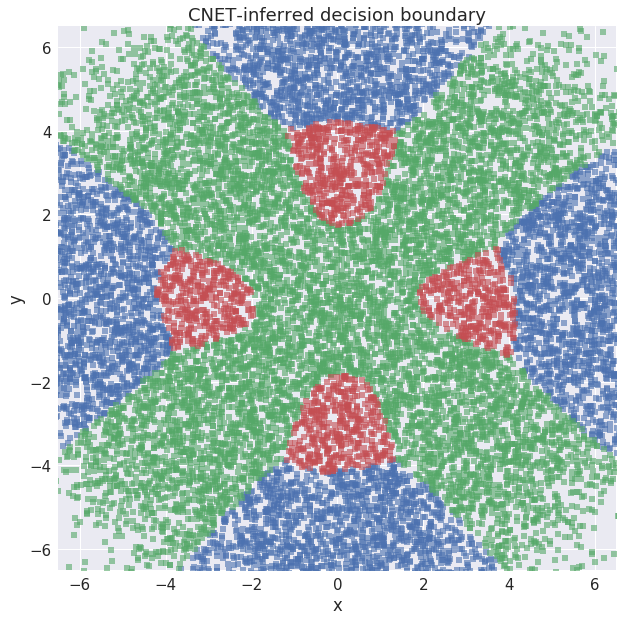

In [13]:
#scatterplot showing model's predicted decision boundaries
xy_rng = (-6.5, 6.5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('CNET-inferred decision boundary')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/cnet_decision_boundary.png')

In [14]:
#model accuracy
idx = (df['class'] == df['class_pred'])
accuracy = idx.sum()*1.0/len(idx)
print 'model accuracy = ', accuracy

model accuracy =  0.6436


In [15]:
#save model
model.save('cnet_model.h5') 

In [16]:
#done
time_stop = tm.time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

execution time (minutes) =  69.7417192817
